Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score

### Gather data, determine the method of data collection and provenance of the data.
The dataset I have selected for this project is a collection of sonar readings intended for a binary classification task in mining.  
A frequency-modulated signal was transmitted via sonar at multiple angles and an integrated energy reading was recorded as each datapoint.  
The dataset has lables ("R" for "rock" and "M" for "mine", which is actually a metal cylinder). Numberic values for labels are monotonic with angle, but do not directly encode angle.  
This dataset and its associated documentation is available at this URL: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
The authors/maintainers request that users cite the following: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Identify a Deep Learning Problem
The clear deep learning problem for this dataset is to maximize correct classification of observations as "rock" or "mine" based on sonar data.  
Because this dataset has a relatively high number of features relative to the total number of observations, and it's structurable in a tabular fashion, it is a good candidate for iterative testing of multilayer perceptron models.  
If this was approached using many of the traditional statistical techniques, the data would need to be significantly down-sampled (through procedures like principal component analysis or variable selection techniques) to account for this charactieristic.

### Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
The raw data is imported as a Pandas dataframe.  
There are no headers (nor are there meaningful descriptions of each angular measurement).  
The first 60 columns are all floats and the last column is the character encoding for the label for each observation  
There are 208 samples (111 "mine" samples and "97" rock samples) and there is no missing data.  
Comparing the distribution of observations in each variable when grouped by sample type shows significant overlap.  
(I.E. There is no single variable which provides linear or other straightforward separability between the two sample types.)  
The data is split into numpy arrays in preparation for an 80:20 train:test split and the split is performed with stratification to avoid introducing bias.  
Additionally, the labels are converted from characters to a binary ("M" = 0, "R" = 1).  
The predictors are standardized in the pipeline because the ranges on predictors vary by a factor of more than 15x.

In [2]:
raw_data = pd.read_table("sonar/sonar.all-data", header=None, delimiter = ",")
display(raw_data.head())
print("raw_data.shape {}".format(raw_data.shape))
print("Count 'rock' {}".format(raw_data[raw_data[60] == "R"].shape[0]))
print("Count 'mine' {}".format(raw_data[raw_data[60] == "M"].shape[0]))
print("Missing: {}".format(raw_data.isnull().sum().sum()))

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


raw_data.shape (208, 61)
Count 'rock' 97
Count 'mine' 111
Missing: 0


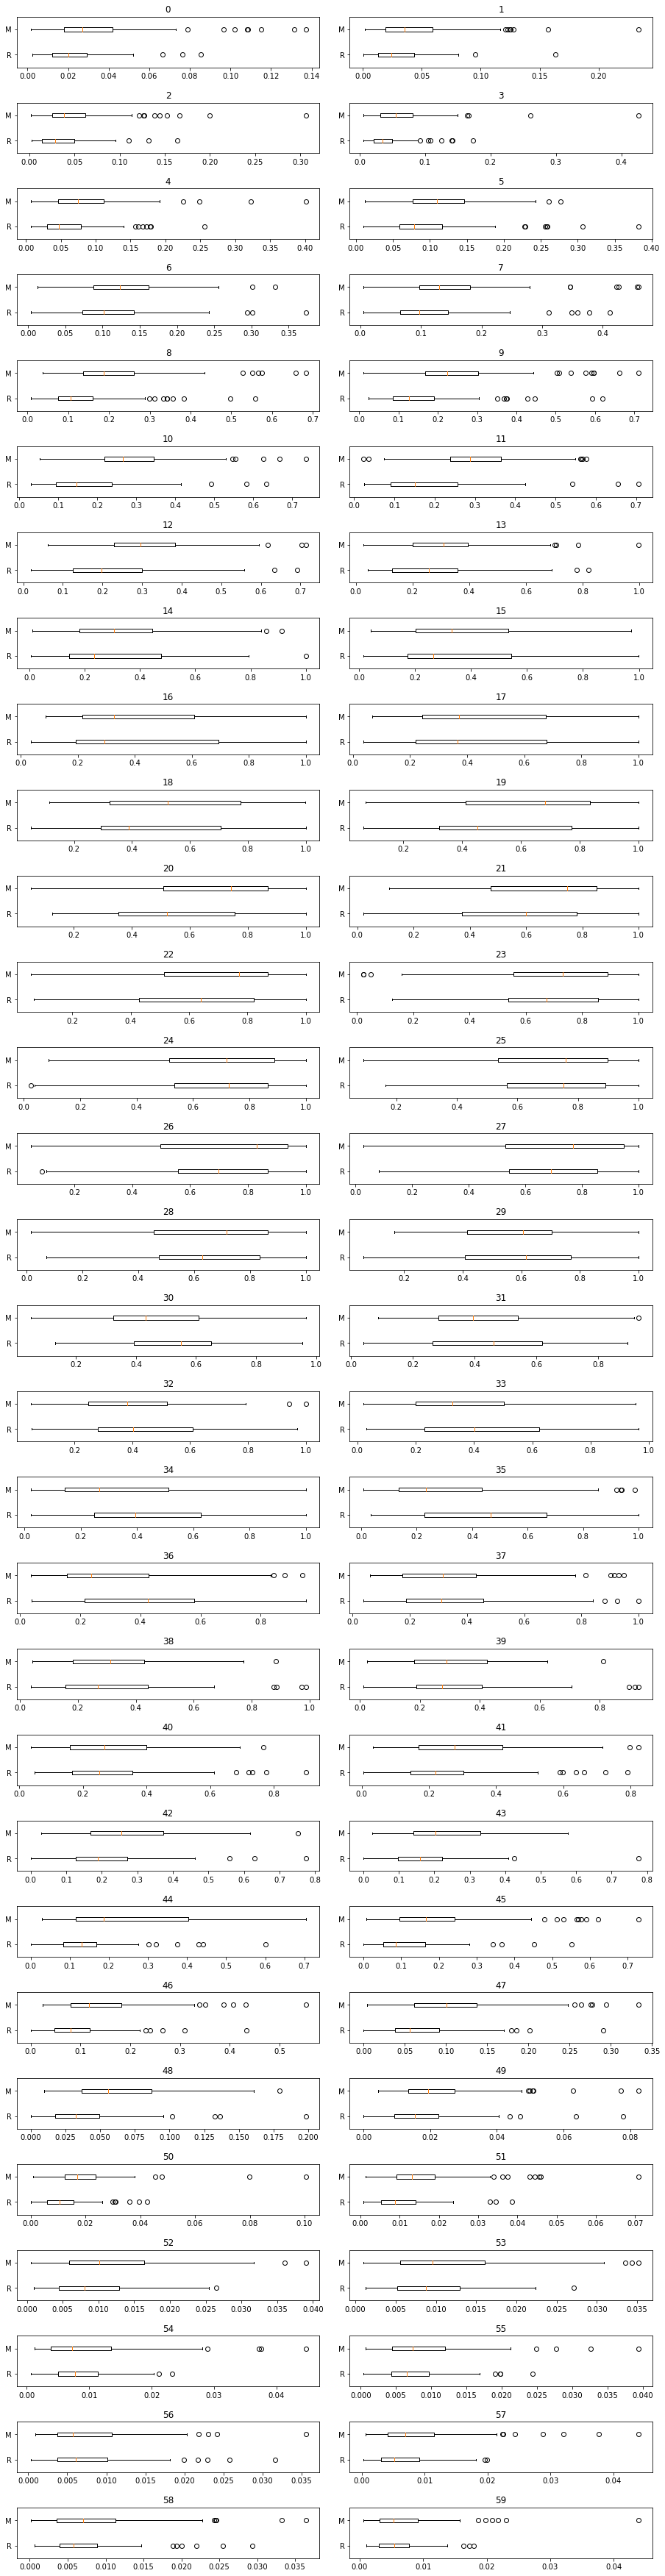

In [3]:
num_rows, num_columns = 30, 2
fig, axs = plt.subplots(num_rows, num_columns, figsize = (15,60))
for row in range(num_rows):
    for col in range(num_columns):
        var_name = (row*num_columns)+col
        r_vals = raw_data.loc[raw_data[60] == "R",var_name].to_list()
        m_vals = raw_data.loc[raw_data[60] == "M",var_name].to_list()
        axs[row, col].set_title(str(var_name))
        axs[row, col].boxplot([r_vals, m_vals], vert = False)
        axs[row, col].set_yticks([1,2],["R", "M"])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.7)
plt.show()       

In [4]:
X = raw_data.iloc[:,0:60].to_numpy()
print(f"X.shape: {X.shape}")
y_str = raw_data.iloc[:,60].to_list()
y = np.array([0 if (i == "M") else 1 for i in y_str])
print(f"y.shape: {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")
print(f"y_train proportion 'R': {y_train.sum()/y_train.shape[0]}")
print(f"y_test proportion 'R': {y_test.sum()/y_test.shape[0]}")

X.shape: (208, 60)
y.shape: (208,)
X_train.shape: (166, 60)
X_test.shape: (42, 60)
y_train.shape: (166,)
y_test.shape: (42,)
y_train proportion 'R': 0.463855421686747
y_test proportion 'R': 0.47619047619047616


<b>Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions</b><br>


In [5]:
#Helper function for performance metrics
def multi_score(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    c_m = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    return {"accuracy": accuracy, "confusion_matrix": c_m, "precision":precision, "recall":recall}

In [6]:
#Helper function for iterative model building
def piped_MLP(X_train, y_train, X_test, y_test, hidden_layer_sizes, activation, solver, max_iter, random_state = 0):
    MLP = MLPClassifier(
        hidden_layer_sizes = hidden_layer_sizes,
        activation = activation, 
        solver = solver,
        max_iter = max_iter,
        random_state = random_state
    )
    pipe = Pipeline([("scaler", StandardScaler()),("mlp", MLP)])
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    ms = multi_score(y = y_test, y_hat = predictions)
    out_dict = {"pipe": pipe, "predictions": predictions, "ms": ms}
    return out_dict
def pretty_multi_score(ms):
    print("\tAccuracy: {}".format(ms["accuracy"]))
    print("\tPrecision: {}".format(ms["precision"]))
    print("\tRecall: {}".format(ms["recall"]))
    print("\tConfusion Matrix:")
    print("\t{}".format(ms["confusion_matrix"][0]))
    print("\t{}".format(ms["confusion_matrix"][1]))

In [7]:
print("Model 1")
model1 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (100,), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model1["ms"])

Model 1
	Accuracy: 0.8571428571428571
	Precision: 0.9375
	Recall: 0.75
	Confusion Matrix:
	[21  1]
	[ 5 15]


In [8]:
print("Model 2")
model2 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (200,), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model2["ms"])

Model 2
	Accuracy: 0.8809523809523809
	Precision: 0.9411764705882353
	Recall: 0.8
	Confusion Matrix:
	[21  1]
	[ 4 16]


In [9]:
print("Model 3")
model3 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (300,), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model3["ms"])

Model 3
	Accuracy: 0.8809523809523809
	Precision: 0.9411764705882353
	Recall: 0.8
	Confusion Matrix:
	[21  1]
	[ 4 16]


In [10]:
print("Model 4")
model4 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (100,100), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model4["ms"])

Model 4
	Accuracy: 0.9047619047619048
	Precision: 0.9444444444444444
	Recall: 0.85
	Confusion Matrix:
	[21  1]
	[ 3 17]


In [11]:
print("Model 5")
model5 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (100,100,100), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model5["ms"])

Model 5
	Accuracy: 0.9047619047619048
	Precision: 0.9444444444444444
	Recall: 0.85
	Confusion Matrix:
	[21  1]
	[ 3 17]


In [12]:
print("Model 6")
model6 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (100,100,100), activation = "tanh", solver = "adam", max_iter = 300)
pretty_multi_score(model6["ms"])

Model 6
	Accuracy: 0.8095238095238095
	Precision: 0.875
	Recall: 0.7
	Confusion Matrix:
	[20  2]
	[ 6 14]


In [13]:
print("Model 7")
model7 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (100,100,100), activation = "logistic", solver = "adam", max_iter = 300)
pretty_multi_score(model7["ms"])

Model 7
	Accuracy: 0.7380952380952381
	Precision: 0.8
	Recall: 0.6
	Confusion Matrix:
	[19  3]
	[ 8 12]


In [14]:
print("Model 8")
model8 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (50,), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model8["ms"])

Model 8
	Accuracy: 0.8095238095238095
	Precision: 0.8333333333333334
	Recall: 0.75
	Confusion Matrix:
	[19  3]
	[ 5 15]


C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
print("Model 9")
model9 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (50,50), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model9["ms"])

Model 9
	Accuracy: 0.8571428571428571
	Precision: 1.0
	Recall: 0.7
	Confusion Matrix:
	[22  0]
	[ 6 14]


In [16]:
print("Model 10")
model10 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (50,50,50), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model10["ms"])

Model 10
	Accuracy: 0.8333333333333334
	Precision: 0.8823529411764706
	Recall: 0.75
	Confusion Matrix:
	[20  2]
	[ 5 15]


In [17]:
print("Model 11")
model11 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (50,100,50), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model11["ms"])

Model 11
	Accuracy: 0.8809523809523809
	Precision: 0.8571428571428571
	Recall: 0.9
	Confusion Matrix:
	[19  3]
	[ 2 18]


In [18]:
print("Model 12")
model12 = piped_MLP(X_train, y_train, X_test, y_test, 
          hidden_layer_sizes = (50,100,200,100,50), activation = "relu", solver = "adam", max_iter = 300)
pretty_multi_score(model12["ms"])

Model 12
	Accuracy: 0.8095238095238095
	Precision: 0.8
	Recall: 0.8
	Confusion Matrix:
	[18  4]
	[ 4 16]


### Analysis Results
<table>
    <tr><th>Model<br>Number</th><th>Hidden<br>Layer<br>Sizes</th><th>Activation</th><th>Solver</th><th>Max<br>Iterations</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>Notes</th></tr>
    <tr><td>1</td><td>(100)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.857</td><td>0.938</td><td>0.750</td><td>Default parameters for sklearn MLP</td></tr>
    <tr><td>2</td><td>(200)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.881</td><td>0.941</td><td>0.800</td><td>Slight improvement</td></tr>
    <tr><td>3</td><td>(300)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.881</td><td>0.941</td><td>0.800</td><td>Literally no performance difference</td></tr>
    <tr><td>4</td><td>(100,100)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.905</td><td>0.944</td><td>0.850</td><td>Slight improvement</td></tr>
    <tr><td>5</td><td>(100,100,100)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.905</td><td>0.944</td><td>0.850</td><td>No improvement</td></tr>
    <tr><td>6</td><td>(100,100,100)</td><td>TanH</td><td>Adam</td><td>300</td><td>0.810</td><td>0.875</td><td>0.700</td><td>Significant performance drop</td></tr>
    <tr><td>7</td><td>(100,100,100)</td><td>Logistic</td><td>Adam</td><td>300</td><td>0.738</td><td>0.800</td><td>0.600</td><td>Significant performance drop</td></tr>
    <tr><td>8</td><td>(50)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.810</td><td>0.833</td><td>0.750</td><td>Failed to converge in 300 iterations.</td></tr>
    <tr><td>9</td><td>(50,50)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.857</td><td>1.000</td><td>0.700</td><td>Highest precision so far.</td></tr>
    <tr><td>10</td><td>(50,50,50)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.833</td><td>0.882</td><td>0.750</td><td>Improved recall but worse accuracy and precision.</td></tr>
    <tr><td>11</td><td>(50,100,50)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.881</td><td>0.857</td><td>0.900</td><td>Decreased accuracy but improved precision and recall.</td></tr>
    <tr><td>12</td><td>(50,100,200,100,50)</td><td>ReLU</td><td>Adam</td><td>300</td><td>0.810</td><td>0.800</td><td>0.8</td><td>Performance decrease with significant complexity increase.</td></tr>
</table>
<br>

### Discussion
It seems reasonable to suggest that model #4 is the best performer out of the twelve models tested.  
Model #5 had identical performance but significantly higher complexity.  
Model #2 had slightly lower performance, but significantly lower complexity. Because it had a single hidden layer, it would be much easier to identify which features in the dataset provide the most predictive capability. (Note, this is not included because a 200-unit visualization with weights will not fit into any static output method in a Jupyter Notebook.)
  
Changing activation functions to anything other than ReLU (Rectified Linear Unit) tanked performance.  
Other optimizers were not tested, as every time I have used another optimizer I’ve had both slower and worse performance.  
Model #9 is noteworthy for its perfect precision, but this comes at the cost of reduced accuracy and recall compared to other models.  
I was surprised to see how much detriment excessive model complexity caused, as evidenced by models #10-12.  
### Conclusion
A potential limitation on the cap of accuracy for predictive models built from this dataset arises from the fact that measurements for the two categories of samples were taken different but aggregated inseparably. (Specifically, measurements represent different angles over either a 90 degree range or a 180 degree range, depending on the sample, but because there is insufficient information about the angles used, it’s not possible to subset matching angular values with any confidence.)  
Iterative model development peaked rather rapidly at accuracy levels approximating the values in the dataset authors’ notes. (These are not compared directly, because the authors used resampling techniques that are beyond the scope of this assignment to address biases in train/test splitting.)  
Additionally, because the test dataset contained fewer than 50 observations, there are models which have identical performance metrics which may not be identical with a larger dataset, as there are a finite number of combinations of predictions and ground truth values, and consequently, a finite number of fitness metric values.  
It is worthwhile to consider in future model building that, past some point, additional complexity leads to decreased performance (probably due to overfitting).  
Additionally, in production environments, run-times and robustness may need to be considered in a way that was not feasible within the scope of this project.  
For tabular datasets which are not linearly separable and have a large number of predictor variables relative to the total number of observations, a multilayer perception is likely a good choice as a first-pass analysis tool.  